<a href="https://colab.research.google.com/github/Sinanbozdag1/NLP-Project-/blob/main/ProjectPrimaryModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Reading and cleaning references**

In [ ]:
data = []

In [ ]:
import json
import numpy as np
import re
import torch.nn.functional as F
import statistics as stats

def reader():
  data = []
  count=0 
  with open('/content/drive/MyDrive/APS360-Project /arxiv-metadata-oai-snapshot.json', 'r') as f:
      for i,line in enumerate(f):
        if json.loads(line)["journal-ref"] is not None:
          data.append(json.loads(line))
        count+=1
        if count ==2000000: #Take only a sample of 1000 papers (1000 is randomly chosen)
          return data
      return data

In [ ]:
#JR_data(reader(),100)
data=reader()

**Cleaning Abstracts**

In [ ]:
#cleans the abstracts from the special characters 
def abstract_data(array,count):
  abstract = []
  for i in range(count):
    abstract.append(array[i]["abstract"]) 
  abstract = [re.sub('[^a-zA-Z]+', ' ', _) for _ in abstract]
  return abstract


In [ ]:
#grabs specified label and input for specified paper in a list
def broad_paper_data(paper,label,input):
  broad_paper_info = []
  labstring = re.sub('[^a-zA-Z]+', '', paper[label])
  broad_paper_info.append(labstring)
  instring=paper[input].strip()
  instring=instring.replace('\n',"")
  instring = re.sub('[^a-zA-Z0-9]+', ' ', paper[input])
  broad_paper_info.append(instring)
  return broad_paper_info

In [ ]:
broad_paper_data(data[1],"journal-ref","abstract")

['IllinoisJMathno',
 ' In this paper we show how to compute the Lambda alpha norm alpha ge 0 using the dyadic grid This result is a consequence of the description of the Hardy spaces H p R N in terms of dyadic and special atoms ']

In [ ]:
#grabs all the papers data(label and input), within specified range, and puts them in a list
def list_raw(start, stop, data,label,input):
  list_papers = []
  for i in range(start,stop):
    list_papers.append(broad_paper_data(data[i],label,input))
  return list_papers

In [ ]:
#Grabs the labels which have more papers assigned to it than the specified minimum count
def relevant_labels(start, stop, data, label, input,min):
  class_count = dict()
  for i in list_raw(start,stop,data,label,input):
    if i[0] in class_count:
      class_count.update({i[0]:class_count[i[0]]+1})
    else:
      class_count.update({i[0]:1})
  p = []
  for k,v in class_count.items():
    if v > min:
      p.append(k)
  return p

In [ ]:
#grabs a list of paper data, with specified minimum and maximum number of entries
def list_data(start, stop, final_stop, data, label, input, min, max):
  list_papers = []
  class_tally = dict()
  r = relevant_labels(start, stop, data, label, input,min)
  for i in range(start,stop):
    d = broad_paper_data(data[i],label,input)
    if d[0] in class_tally:
      class_tally.update({d[0]:class_tally[d[0]]+1})
    else:
      class_tally.update({d[0]:1})
    if d[0] in r and class_tally[d[0]]<max+1:
      list_papers.append(d)
    if len(list_papers) == final_stop:
      return list_papers
  return list_papers

In [ ]:
import random
new_list= list_data(0,len(data),len(data),data,"journal-ref","abstract",6000,12000) #creates 13 different possible journals 
random.shuffle(new_list)#in order to get balanced population samples 

Run the next 3 cells in sequence to obtain basic metrics of the processed dataset

In [ ]:
class_count = dict()
for i in new_list:
  if i[0] in class_count:
    class_count.update({i[0]:class_count[i[0]]+1})
  else:
    class_count.update({i[0]:1})

In [ ]:
print("number of labels: "+ str(len(class_count.keys())))
print("min entries: " +str(min(class_count.values())))
print("max entries: " +str(max(class_count.values())))
print("mean entires per label: "+ str(stats.mean(class_count.values())))
print(class_count)
#remove lowest counts

number of labels: 13
min entries: 6485
max entries: 12000
mean entires per label: 10906.615384615385
{'PhysRevE': 12000, 'EurPhysJC': 6485, 'PhysRevC': 11623, 'PhysRevD': 12000, 'NuclPhysB': 10488, 'PhysRevA': 12000, 'AstrophysJ': 12000, 'PhysRevLett': 12000, 'JHEP': 12000, 'PhysLettB': 12000, 'PhysRevB': 12000, 'MonNotRoyAstronSoc': 7549, 'AAA': 9641}


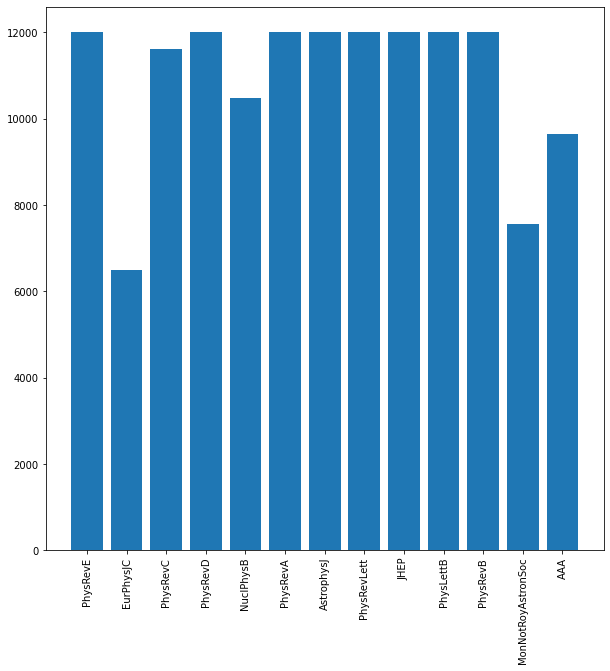

fig.1: Number of entries for each category


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.bar(range(len(class_count)), list(class_count.values()), align='center')
plt.xticks(range(len(class_count)), list(class_count.keys()))
plt.xticks(rotation=90)
plt.show()
print("fig.1: Number of entries for each category") #used for presenting how much sample does each journal-reference have 

In [ ]:
print(np.size(data))
print(type(data[0]))
print(data[0]["abstract"])
print(data[0]["journal-ref"])

722871
<class 'dict'>
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of eve

**Create an embedding**

In [ ]:
#Download the word embeddings 
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50) #50 dimensional matrix for each word glove embedding 

.vector_cache/glove.6B.zip: 862MB [02:43, 5.27MB/s]                           
100%|█████████▉| 399439/400000 [00:13<00:00, 29826.66it/s]

**Integer encoding of the categories**

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# get the one hot encoding for the first 10 sample papers 
# i.e. hep-ph is the category of the first paper and math is the category of the second paper  


cate_list=[]
for i in new_list:           
  cate_list.append(i[0])

values = array(cate_list)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values) # integer encoding for multi classification problem 


In [ ]:
cate_list=set(cate_list)
print(len(cate_list))
print(cate_list) #all the unique journal-references 

13
{'PhysLettB', 'PhysRevD', 'PhysRevE', 'PhysRevC', 'EurPhysJC', 'PhysRevLett', 'MonNotRoyAstronSoc', 'JHEP', 'PhysRevB', 'PhysRevA', 'AAA', 'AstrophysJ', 'NuclPhysB'}


In [ ]:
#creating an embedding as an integer 
glove1=glove.stoi["hey"]
print(glove1)

#creating an embedding as a vector 
glove2=glove["hey"]
print(glove2)

#First option is more memory efficient so we will use the index of each word gethered from the glove.stoi["word"]

7942
tensor([-0.7001,  0.3678,  0.3442, -0.4232, -0.0460, -0.6607, -0.3399,  0.1827,
        -0.9286,  0.5684, -0.4382,  0.7083, -0.4746, -0.0793,  1.0187,  0.2213,
         0.4307,  0.7672,  0.1877, -0.4921, -0.5306,  0.5638,  0.6357,  0.6462,
         1.2649, -0.8290, -1.3903,  0.3749,  0.6132, -1.5994,  1.3005,  0.6435,
        -0.5800,  1.0372, -0.2716, -0.4338,  0.8554, -0.8967,  0.8018, -0.3333,
        -0.1765, -0.1228, -0.7051, -0.2841,  0.7115, -0.1349,  0.0495, -0.8134,
         0.3429,  1.0381])


In [ ]:
#Input: a list of lists (the lists are in the form of journal ref, paper)
#Output: a journal 
import torch

#We will split the text into words in order to get an embedding for each word.
def split_paper(paper):
    paper = paper.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return paper.lower().split()


#We will look up the GloVe embedding of each paper. 
def get_paper_vectors(glove_vector):
    emb_list=[]
    for i, line in enumerate(new_list):  
      title=line[1]
      #We will sum up all the embeddings to get a total embedding per paper 
      title_emb = sum(glove_vector[w] for w in split_paper(title))              #(physc,abstract) ([[989,9239]], tensor(8))
      idxs = [glove_vector.stoi[w] for w in split_paper(title) if w in glove_vector.stoi]
      if not idxs:
        continue 
      idxs = torch.tensor(idxs)
      #label_emb is the tensor that represents the category that the paper is in (i.e. tensor(4) represents math)
      label_emb=torch.tensor(integer_encoded[i]) #label=torch.tensor(cate_encoded[i])
      #title_emb= embedding of the title and the label_emb = category 
      emb_list.append((idxs,label_emb))
     

    #split the data  
    split = int(len(emb_list) * 0.6) #split at 60%
    split2 = int(len(emb_list) * 0.2)+split
    train, valid, test = emb_list[:split], emb_list[split:split2] , emb_list[split2:]
    #print(train[0])
    return  train, valid, test 

 

#Load the training, validation and testing list of lists 

train,valid,test= get_paper_vectors(glove)

#train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
#valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)


#We will use a fully-connected NN to predict which journals are likely to accept.

(tensor([    53,    806,      0,    299,   6145, 108409,      6,     55,  10381,
            42,  33541,      6,   5523,     25,   1224,   1846, 108409,  25155,
           131, 132844,   6646,   3001,   1947,   3390,  25224,     32,   1789,
            10,    917,   5523,     13,  13789,   1249,  69505,     60,      4,
           437,   2653,   5025, 182836,     25,  14346,   1275,  18033,     53,
           596,     12,      0,   1423,  23710,      7,   6860,   2953,   3669,
            42,     10,    130,  14346,    223,      3,   5523,   2625,     75,
             0,  43583,      3,   1224,  19919, 108409,     22,      0,   2514,
             3,  13865,   2064,     53,   2387,      0,  18681,   2653,  29758,
           176,  21929,   1343,  57523,    422,      5,      0,  56270,  10132,
          1968,  36720,   3880,    176,  60738,    409,    632,     42,     32,
            36,   3024,      4,    176,  21929,    314,    409,      5,   1968,
         36720,   3880,   7316,   2998,

**Train the model**

In [ ]:
#Long short term memory model 
import torch.nn as nn

class PaperLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(PaperLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size,2, batch_first=True) #2 specifies the number of LSTM layers 
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(2, x.size(0), self.hidden_size, device="cuda")  #2 specifies the number of LSTM layers    
        c0 = torch.zeros(2, x.size(0), self.hidden_size, device="cuda")
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


################################# EXPLANATION #############################################

#the num_classes should be equal to the number of journals exist therefore there are num_classes always equal 13 
#always input_size = 50 
#the hidden_size will be hypertuned 
#Calling the model: PaperLSTM(50,50,13)
#Use self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True) or self.rnn = nn.LSTM(input_size, hidden_size,2, batch_first=True) where added 2 means the 2 lstm layers 

#What to tune:
#hidden_size
#lstm layers

In [ ]:
import random

class AbstractBatcher:
    def __init__(self, abstracts, batch_size=32, drop_last=False):
        # store tweets by length
        self.abstracts_by_length = {}
        for words, label in abstracts:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.abstracts_by_length:
                self.abstracts_by_length[wlen] = []
            self.abstracts_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {alen : torch.utils.data.DataLoader(
                                    abstracts,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for alen, abstracts in self.abstracts_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)
                
train_loader = AbstractBatcher(train, batch_size=64) #HYPERPARAMETER 
valid_loader = AbstractBatcher(valid, batch_size=64)
test_loader = AbstractBatcher(test, batch_size=64)

#################################EXPLANATION#############################################

#What to tune:
#batch_size


In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
import scipy.signal as sg
from PIL import Image
import torch.optim as optim #for gradient descent
import requests

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for abstracts, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          model=model.cuda()
          abstracts = abstracts.cuda()
          labels = labels.cuda()
        ############################################# 
        output = model(abstracts)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [ ]:
def get_model_name(name,learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name,
                                            learning_rate,
                                            epoch)

    return path

In [ ]:
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    print("training started:")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)#add a regularization 
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs): 
        for abstracts, labels in train_loader:  
            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              model=model.cuda()
              abstracts = abstracts.cuda()
              labels = labels.cuda()
            ############################################# 
            optimizer.zero_grad()
            pred = model(abstracts)
            loss = criterion(pred, labels) #getting an error since labels is an embedding from the glove, since it's a multiclassification problem 
            loss.backward()
            optimizer.step()
        losses.append(float(loss))     
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))
        #Save the model name 
        model_path = get_model_name(model,learning_rate, num_epochs)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
#################################EXPLANATION#############################################

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5); weight_decay is added to reduce the overfitting and can be tuned 

#What to tune:
#weight_decay=1e-5
#num_epochs
#learning rate


**Training the Model 1**

training started:
Epoch 1; Loss 1.787777; Train Acc 0.361876; Val Acc 0.127350
Epoch 2; Loss 1.533877; Train Acc 0.471276; Val Acc 0.439458
Epoch 3; Loss 0.671800; Train Acc 0.489778; Val Acc 0.488781
Epoch 4; Loss 1.245899; Train Acc 0.519534; Val Acc 0.361552
Epoch 5; Loss 1.390033; Train Acc 0.519372; Val Acc 0.416697
Epoch 6; Loss 1.565523; Train Acc 0.525126; Val Acc 0.366404
Epoch 7; Loss 1.234728; Train Acc 0.557537; Val Acc 0.519790
Epoch 8; Loss 1.177567; Train Acc 0.550960; Val Acc 0.437356
Epoch 9; Loss 1.105300; Train Acc 0.564019; Val Acc 0.502122
Epoch 10; Loss 1.195644; Train Acc 0.561067; Val Acc 0.489873
Epoch 11; Loss 1.175982; Train Acc 0.576228; Val Acc 0.497392
Epoch 12; Loss 1.543325; Train Acc 0.586254; Val Acc 0.540813
Epoch 13; Loss 1.252046; Train Acc 0.573614; Val Acc 0.403234
Epoch 14; Loss 1.198134; Train Acc 0.576956; Val Acc 0.467758
Epoch 15; Loss 0.811845; Train Acc 0.597332; Val Acc 0.523550
Epoch 16; Loss 1.140122; Train Acc 0.581147; Val Acc 0.495209

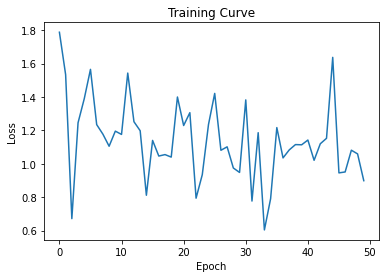

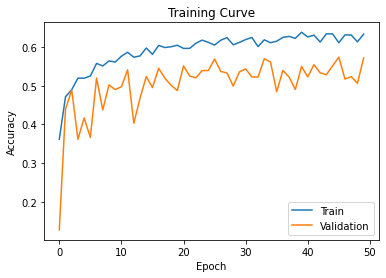

In [ ]:
model = PaperLSTM(50, 100, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01) 
#batch_size=150 trial and Adam optimizer and regularization (weight_decay=1e-5)
#2 lstm layers 

**Training the Model 2**

training started:
Epoch 1; Loss 1.964510; Train Acc 0.273782; Val Acc 0.266909
Epoch 2; Loss 1.714920; Train Acc 0.378721; Val Acc 0.372226
Epoch 3; Loss 1.522680; Train Acc 0.429944; Val Acc 0.412937
Epoch 4; Loss 1.425038; Train Acc 0.441655; Val Acc 0.432302
Epoch 5; Loss 1.676911; Train Acc 0.458837; Val Acc 0.445927
Epoch 6; Loss 1.197589; Train Acc 0.496975; Val Acc 0.475318
Epoch 7; Loss 1.316609; Train Acc 0.500681; Val Acc 0.481342
Epoch 8; Loss 1.405802; Train Acc 0.503928; Val Acc 0.481100
Epoch 9; Loss 1.315372; Train Acc 0.521043; Val Acc 0.493713
Epoch 10; Loss 1.663088; Train Acc 0.469389; Val Acc 0.448353
Epoch 11; Loss 1.320090; Train Acc 0.526703; Val Acc 0.496463
Epoch 12; Loss 1.392845; Train Acc 0.529088; Val Acc 0.502446
Epoch 13; Loss 1.886126; Train Acc 0.536608; Val Acc 0.496867
Epoch 14; Loss 1.274257; Train Acc 0.544357; Val Acc 0.511502
Epoch 15; Loss 1.335092; Train Acc 0.495546; Val Acc 0.470022
Epoch 16; Loss 1.157664; Train Acc 0.531339; Val Acc 0.498201

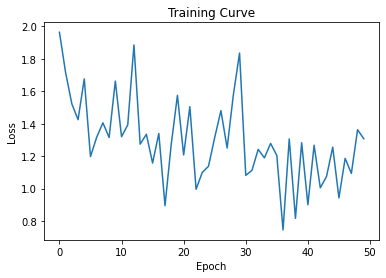

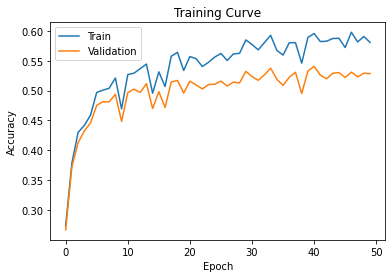

0.5289266221952699

In [ ]:
#INCREASE THE HIDDEN_SIZE AND REDUCE THE BATCH_SIZE 

model = PaperLSTM(50, 100, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#batch_size=32 trial and Adam optimizer and regularization (weight_decay=1e-5)
get_accuracy(model, test_loader) #print the predictions


**Training the Model 3**

training started:
Epoch 1; Loss 1.654275; Train Acc 0.378465; Val Acc 0.366121
Epoch 2; Loss 1.418488; Train Acc 0.391806; Val Acc 0.380069
Epoch 3; Loss 1.276228; Train Acc 0.458352; Val Acc 0.437518
Epoch 4; Loss 1.084205; Train Acc 0.494562; Val Acc 0.469780
Epoch 5; Loss 1.396795; Train Acc 0.506772; Val Acc 0.484294
Epoch 6; Loss 1.220336; Train Acc 0.498470; Val Acc 0.471478
Epoch 7; Loss 1.044495; Train Acc 0.525841; Val Acc 0.492945
Epoch 8; Loss 1.919925; Train Acc 0.538724; Val Acc 0.504306
Epoch 9; Loss 1.506446; Train Acc 0.546176; Val Acc 0.514736
Epoch 10; Loss 1.381577; Train Acc 0.537565; Val Acc 0.510329
Epoch 11; Loss 0.419363; Train Acc 0.566256; Val Acc 0.530342
Epoch 12; Loss 1.136897; Train Acc 0.559450; Val Acc 0.521771
Epoch 13; Loss 1.360971; Train Acc 0.552766; Val Acc 0.515989
Epoch 14; Loss 1.194893; Train Acc 0.561296; Val Acc 0.525045
Epoch 15; Loss 1.248296; Train Acc 0.571606; Val Acc 0.533414
Epoch 16; Loss 1.524518; Train Acc 0.501691; Val Acc 0.468809

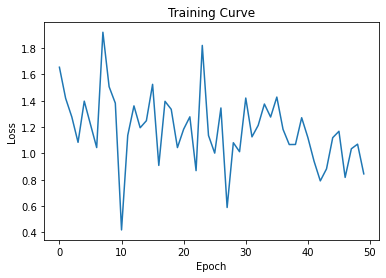

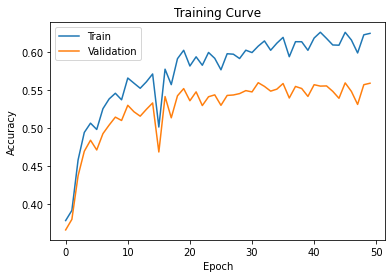

0.5590863149383465

In [ ]:
#INCREASE THE HIDDEN_SIZE 

model = PaperLSTM(50, 75, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)#2 lstm layers, batch_size=64 trial and Adam optimizer and regularization (weight_decay=1e-5)

get_accuracy(model, test_loader) #print the predictions

**Training the Model 4**

training started:
Epoch 1; Loss 1.659829; Train Acc 0.380338; Val Acc 0.372589
Epoch 2; Loss 1.456297; Train Acc 0.435052; Val Acc 0.421346
Epoch 3; Loss 1.224239; Train Acc 0.456546; Val Acc 0.439903
Epoch 4; Loss 1.489047; Train Acc 0.468944; Val Acc 0.447423
Epoch 5; Loss 1.172357; Train Acc 0.457166; Val Acc 0.442854
Epoch 6; Loss 1.278495; Train Acc 0.512257; Val Acc 0.490034
Epoch 7; Loss 1.130623; Train Acc 0.524924; Val Acc 0.506610
Epoch 8; Loss 1.491684; Train Acc 0.541850; Val Acc 0.513928
Epoch 9; Loss 1.449081; Train Acc 0.547470; Val Acc 0.515221
Epoch 10; Loss 0.628485; Train Acc 0.528428; Val Acc 0.499656
Epoch 11; Loss 0.969336; Train Acc 0.552092; Val Acc 0.519426
Epoch 12; Loss 1.637584; Train Acc 0.548117; Val Acc 0.521488
Epoch 13; Loss 1.126626; Train Acc 0.556822; Val Acc 0.522903
Epoch 14; Loss 1.345977; Train Acc 0.573897; Val Acc 0.539074
Epoch 15; Loss 0.951913; Train Acc 0.569706; Val Acc 0.529533
Epoch 16; Loss 1.587128; Train Acc 0.554060; Val Acc 0.518253

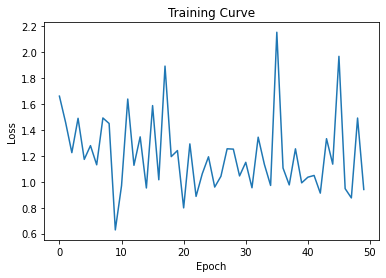

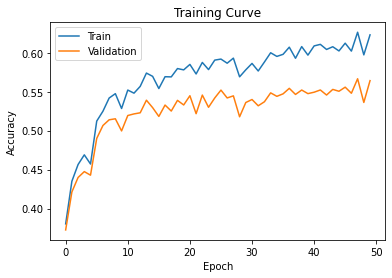

0.5677784515868203

In [ ]:
#DECREASE HIDDEN_SIZE

model = PaperLSTM(50, 50, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#batch_size=64 trial and Adam optimizer and regularization (weight_decay=1e-5)
#2 lstm layers 
get_accuracy(model, test_loader) #print the predictions

**Training the Model 5**

training started:
Epoch 1; Loss 1.515882; Train Acc 0.354545; Val Acc 0.348615
Epoch 2; Loss 1.274774; Train Acc 0.434095; Val Acc 0.422074
Epoch 3; Loss 1.328933; Train Acc 0.498444; Val Acc 0.484213
Epoch 4; Loss 1.410080; Train Acc 0.502325; Val Acc 0.485668
Epoch 5; Loss 1.544336; Train Acc 0.535153; Val Acc 0.516960
Epoch 6; Loss 0.883300; Train Acc 0.538805; Val Acc 0.519022
Epoch 7; Loss 1.568539; Train Acc 0.529493; Val Acc 0.504589
Epoch 8; Loss 1.183236; Train Acc 0.553292; Val Acc 0.526905
Epoch 9; Loss 1.446636; Train Acc 0.572333; Val Acc 0.546836
Epoch 10; Loss 1.327052; Train Acc 0.564612; Val Acc 0.535031
Epoch 11; Loss 1.245610; Train Acc 0.571201; Val Acc 0.539761
Epoch 12; Loss 1.053933; Train Acc 0.590850; Val Acc 0.556580
Epoch 13; Loss 1.048407; Train Acc 0.588127; Val Acc 0.551890
Epoch 14; Loss 1.898378; Train Acc 0.582211; Val Acc 0.546756
Epoch 15; Loss 1.481304; Train Acc 0.590041; Val Acc 0.553386
Epoch 16; Loss 1.019270; Train Acc 0.582683; Val Acc 0.546675

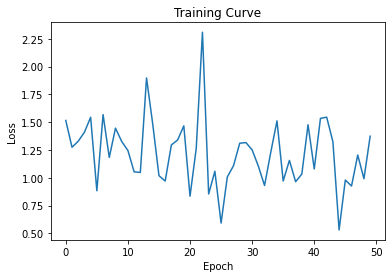

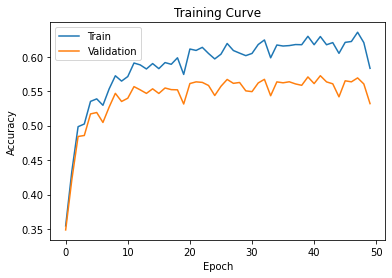

0.5259349100464928

In [ ]:
#INCREASE THE HIDDEN_SIZE

model = PaperLSTM(50, 100, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#batch_size=64 trial and Adam optimizer and regularization (weight_decay=1e-5)
#2 lstm layers 
get_accuracy(model, test_loader) #print the predictions

**Training the Model 6**

training started:
Epoch 1; Loss 1.570656; Train Acc 0.348251; Val Acc 0.341540
Epoch 2; Loss 1.184745; Train Acc 0.414797; Val Acc 0.408288
Epoch 3; Loss 1.265360; Train Acc 0.453285; Val Acc 0.445361
Epoch 4; Loss 1.436449; Train Acc 0.489185; Val Acc 0.478108
Epoch 5; Loss 1.415143; Train Acc 0.472030; Val Acc 0.461128
Epoch 6; Loss 1.393194; Train Acc 0.514601; Val Acc 0.496948
Epoch 8; Loss 1.265656; Train Acc 0.490102; Val Acc 0.473459
Epoch 9; Loss 1.332545; Train Acc 0.523698; Val Acc 0.502567
Epoch 10; Loss 0.908105; Train Acc 0.543993; Val Acc 0.523833
Epoch 11; Loss 0.066434; Train Acc 0.536096; Val Acc 0.515747
Epoch 12; Loss 0.991720; Train Acc 0.555515; Val Acc 0.527269
Epoch 13; Loss 0.979386; Train Acc 0.554127; Val Acc 0.523267
Epoch 14; Loss 0.878193; Train Acc 0.551257; Val Acc 0.520275
Epoch 15; Loss 0.178745; Train Acc 0.562577; Val Acc 0.531150
Epoch 16; Loss 1.173775; Train Acc 0.565528; Val Acc 0.533050
Epoch 17; Loss 0.812735; Train Acc 0.565609; Val Acc 0.53062

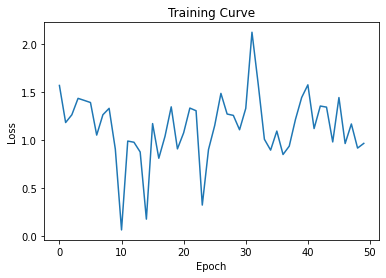

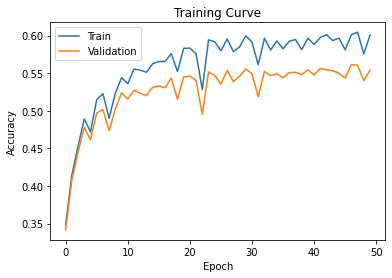

0.5568223165554882

In [ ]:
#DECREASE THE BATCH_SIZE

model = PaperLSTM(50, 50, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#batch_size=32 trial and Adam optimizer and regularization (weight_decay=1e-5)
#2 lstm layers 
get_accuracy(model, test_loader) #print the predictions

**Training the Model 7**

training started:
Epoch 1; Loss 1.543339; Train Acc 0.416005; Val Acc 0.412773
Epoch 2; Loss 1.228315; Train Acc 0.440655; Val Acc 0.432803
Epoch 3; Loss 1.493982; Train Acc 0.456019; Val Acc 0.444652
Epoch 4; Loss 1.523470; Train Acc 0.469067; Val Acc 0.452692
Epoch 5; Loss 1.462972; Train Acc 0.480998; Val Acc 0.465211
Epoch 6; Loss 1.383127; Train Acc 0.495704; Val Acc 0.477871
Epoch 7; Loss 1.372817; Train Acc 0.518296; Val Acc 0.498995
Epoch 8; Loss 1.254832; Train Acc 0.509974; Val Acc 0.495786
Epoch 9; Loss 1.204721; Train Acc 0.545944; Val Acc 0.522693
Epoch 10; Loss 1.652420; Train Acc 0.558863; Val Acc 0.536622
Epoch 11; Loss 1.514598; Train Acc 0.553538; Val Acc 0.528511
Epoch 12; Loss 1.366676; Train Acc 0.538397; Val Acc 0.517897
Epoch 13; Loss 1.327548; Train Acc 0.553843; Val Acc 0.529781
Epoch 14; Loss 1.418720; Train Acc 0.560990; Val Acc 0.534577
Epoch 15; Loss 1.385980; Train Acc 0.563682; Val Acc 0.538738
Epoch 16; Loss 1.042342; Train Acc 0.573838; Val Acc 0.539620

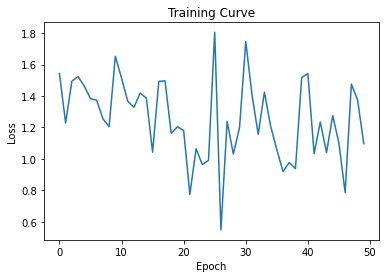

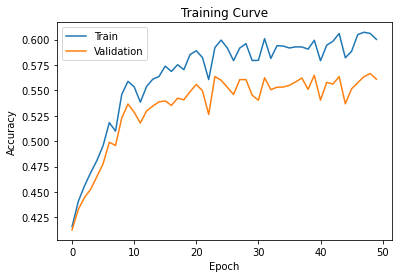

0.5671062839410396

In [ ]:
#RESUFFLE AND AUGMENTE THE DATA (the max boundary= 12000)

model = PaperLSTM(50, 50, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#batch_size=32 trial and Adam optimizer and regularization (weight_decay=1e-5)
#2 lstm layers 
get_accuracy(model, test_loader) #print the predictions

**Training the Model 8**

training started:
Epoch 1; Loss 1.648782; Train Acc 0.388350; Val Acc 0.383024
Epoch 2; Loss 1.513305; Train Acc 0.451409; Val Acc 0.441512
Epoch 3; Loss 1.527204; Train Acc 0.481931; Val Acc 0.468086
Epoch 4; Loss 1.473404; Train Acc 0.501836; Val Acc 0.485363
Epoch 5; Loss 1.312887; Train Acc 0.525924; Val Acc 0.507825
Epoch 6; Loss 1.619605; Train Acc 0.542127; Val Acc 0.518013
Epoch 7; Loss 1.226852; Train Acc 0.552897; Val Acc 0.526666
Epoch 8; Loss 1.433085; Train Acc 0.562635; Val Acc 0.537437
Epoch 9; Loss 1.246656; Train Acc 0.554677; Val Acc 0.527157
Epoch 10; Loss 1.409715; Train Acc 0.530967; Val Acc 0.507181
Epoch 11; Loss 1.205685; Train Acc 0.564568; Val Acc 0.534368
Epoch 12; Loss 1.385290; Train Acc 0.571472; Val Acc 0.544955
Epoch 13; Loss 1.788868; Train Acc 0.556835; Val Acc 0.527311
Epoch 14; Loss 1.191742; Train Acc 0.568567; Val Acc 0.540598
Epoch 15; Loss 1.359599; Train Acc 0.578049; Val Acc 0.544863
Epoch 16; Loss 1.235390; Train Acc 0.572373; Val Acc 0.540966

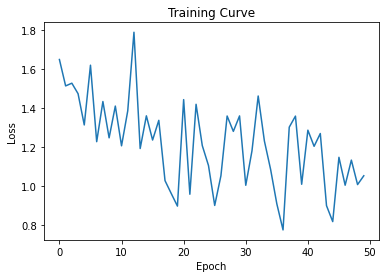

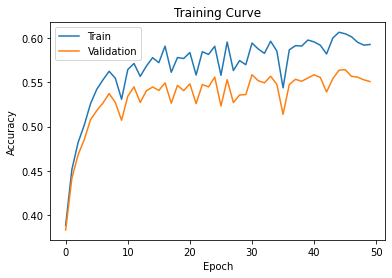

0.5549725367455276

In [ ]:
#RESUFFLE AND AUGMENTE THE DATA (the max boundary= 15000)

model = PaperLSTM(50, 50, 13)
train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#batch_size=32 trial and Adam optimizer and regularization (weight_decay=1e-5)
#2 lstm layers 
get_accuracy(model, test_loader) #print the predictions

**Testing the model with the best validation accuracy**

In [ ]:
model1= PaperLSTM(50, 50, 13)

training started:
Epoch 1; Loss 1.596093; Train Acc 0.406978; Val Acc 0.399443
Epoch 2; Loss 1.177228; Train Acc 0.446180; Val Acc 0.439962
Epoch 3; Loss 2.170148; Train Acc 0.463577; Val Acc 0.454844
Epoch 4; Loss 1.051921; Train Acc 0.478518; Val Acc 0.463977
Epoch 5; Loss 2.093422; Train Acc 0.517991; Val Acc 0.504426
Epoch 6; Loss 1.158750; Train Acc 0.525385; Val Acc 0.506753
Epoch 7; Loss 1.288160; Train Acc 0.549071; Val Acc 0.529217
Epoch 8; Loss 1.153800; Train Acc 0.561707; Val Acc 0.541030
Epoch 9; Loss 1.159999; Train Acc 0.554795; Val Acc 0.533272
Epoch 10; Loss 1.026099; Train Acc 0.565633; Val Acc 0.540995
Epoch 11; Loss 1.064970; Train Acc 0.565022; Val Acc 0.538280
Epoch 12; Loss 1.135432; Train Acc 0.551904; Val Acc 0.530980
Epoch 13; Loss 1.325957; Train Acc 0.575178; Val Acc 0.546250
Epoch 14; Loss 1.498256; Train Acc 0.566762; Val Acc 0.538386
Epoch 15; Loss 1.274843; Train Acc 0.569101; Val Acc 0.541947
Epoch 16; Loss 1.111801; Train Acc 0.576307; Val Acc 0.548471

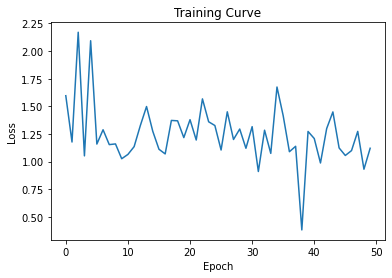

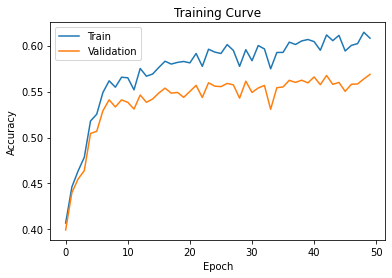

In [ ]:
#RUN THIS WITH BATCH SIZE OF 64
train_network(model1, train_loader, valid_loader, num_epochs=50, learning_rate=0.01)
#2 lstm layers and batch_size=64 and resuffled 

In [ ]:
model1_path=get_model_name(model1,learning_rate=0.01,epoch=50)
state = torch.load(model1_path)
model1.load_state_dict(state)

In [ ]:
get_accuracy(model1, test_loader) #print the predictions

0.5910148811622823